In [374]:

import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom 
from scipy import linalg
import random
from decimal import Decimal
import pydtmc

In [375]:
Decimal(2)

Decimal('2')

In [376]:
## Base parameters
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 50 ## Mean Fee of Getting Caught
nPPL = 11
R = nPPL * .6 # enforcement resources

In [377]:
LobH = [4] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset

In [378]:
def pSS1(t = len(LobH) - 1): #Gets probability of lobbying successfully, subjective
    return 1 - ((.8+CatH[t]) / (1+LobH[t]))

In [379]:
def pSS(nL, nC): #Gets probability of lobbying successfully, subjective
    return 1 - ((.8+nC) / (1+nL))

In [380]:
def pCat(t = len(LobH) - 1):  #Gets objective probability of success 
    if LobH[t] <= R:
        return .8
    else:
        return .8 * (R / LobH[t])

In [381]:
def pCat2(nL):  #Gets objective probability of success 
    if nL <= R:
        return .8
    else:
        return .8 * (R / nL)

In [382]:
def pL(): ## Calculates subjective probability of lobbying
    ps = pSS()
    temp = (-LC + (ps*T))/((1-ps)*mF) ## value that the normal distrobution draw need to be less then to choose to lobby
    return norm(loc = 1, scale = 1).cdf(temp) ## probability of lobbying for individual

In [383]:
def pL(nL, nC): ## Calculates subjective probability of lobbying
    ps = pSS(nL, nC)
    temp = (-LC + (ps*T))/((1-ps)*mF) ## value that the normal distrobution draw need to be less then to choose to lobby
    return norm(loc = 1, scale = 1).cdf(temp) ## probability of lobbying for individual

In [384]:
lis = []
for i in range(0,nPPL+1):
    for r in range(0,nPPL+1):
        lis.append(i)
        
TM = pd.DataFrame({'L': lis }) #Transition Matrix

c = []
for i in range(0,nPPL+1):
    for r in range(0,nPPL+1):
        c.append(r)

TM["C"] = c
TM = TM.drop(TM[TM.C > TM.L].index) ## drop rows where C > L

for i in range(nPPL+1): ## Clear Matrix
    for r in range(0,i+1):
        TM[f"{i},{r}"] = 0

TM = TM.reset_index(drop = True)
TM.head(10)


,L,C,"0,0","1,0","1,1","2,0","2,1","2,2","3,0","3,1",...,"11,2","11,3","11,4","11,5","11,6","11,7","11,8","11,9","11,10","11,11"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [385]:
for l2 in range(2,len(TM)+2):
    tempList = []
    for l1 in range(0,len(TM)):
        pl2 = pL(TM.L[l1], TM.C[l1])  #grabs the probability of lobbying based on t-5 lobbying
        tL, tC = TM.columns[l2].split(",")
        tL = int(tL)
        tC = int(tC)
        pnLob = binom.pmf(tL, nPPL, pl2) ## binomial distrobution, gets probability they lobied that many times
        pcat = pCat2(tL)
        tempList.append(binom.pmf(tC, tL, pcat) * pnLob) ###Appends each value to list   ### This need to be fixed for double digits
    TM[TM.columns[l2]] = tempList

TM

,L,C,"0,0","1,0","1,1","2,0","2,1","2,2","3,0","3,1",...,"11,2","11,3","11,4","11,5","11,6","11,7","11,8","11,9","11,10","11,11"
0,0,0,0.137978,0.059887,0.239550,0.011815,0.094521,0.189043,0.001399,0.016783,...,8.566995e-11,2.372399e-10,4.379813e-10,5.660066e-10,5.224676e-10,3.444841e-10,1.589927e-10,4.892082e-11,9.031537e-12,7.578912e-13
1,1,0,0.059194,0.038161,0.152645,0.011183,0.089462,0.178923,0.001966,0.023594,...,2.853060e-09,7.900780e-09,1.458606e-08,1.884967e-08,1.739970e-08,1.147233e-08,5.294921e-09,1.629206e-09,3.007766e-10,2.523999e-11
2,1,1,0.149525,0.062032,0.248129,0.011698,0.093581,0.187162,0.001324,0.015882,...,5.647735e-11,1.563988e-10,2.887363e-10,3.731361e-10,3.444333e-10,2.270989e-10,1.048149e-10,3.225073e-11,5.953981e-12,4.996348e-13
3,2,0,0.019838,0.018686,0.074744,0.008000,0.064003,0.128005,0.002055,0.024662,...,6.192831e-08,1.714938e-07,3.166039e-07,4.091497e-07,3.776766e-07,2.490176e-07,1.149312e-07,3.536344e-08,6.528635e-09,5.478575e-10
4,2,1,0.106719,0.052962,0.211848,0.011947,0.095577,0.191155,0.001617,0.019404,...,2.893557e-10,8.012928e-10,1.479310e-09,1.911723e-09,1.764668e-09,1.163517e-09,5.370080e-10,1.652332e-10,3.050459e-11,2.559826e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,11,7,0.115794,0.055158,0.220632,0.011943,0.095543,0.191085,0.001552,0.018618,...,2.000111e-10,5.538768e-10,1.022542e-09,1.321439e-09,1.219790e-09,8.042568e-10,3.711955e-10,1.142140e-10,2.108566e-11,1.769426e-12
74,11,8,0.128947,0.058064,0.232258,0.011885,0.095077,0.190154,0.001460,0.017514,...,1.199802e-10,3.322528e-10,6.133897e-10,7.926882e-10,7.317122e-10,4.824476e-10,2.226681e-10,6.851327e-11,1.264860e-11,1.061421e-12
75,11,9,0.140057,0.060289,0.241154,0.011796,0.094370,0.188740,0.001385,0.016618,...,7.939093e-11,2.198518e-10,4.058803e-10,5.245222e-10,4.841743e-10,3.192358e-10,1.473396e-10,4.533526e-11,8.369587e-12,7.023430e-13
76,11,10,0.149525,0.062032,0.248129,0.011698,0.093581,0.187162,0.001324,0.015882,...,5.647735e-11,1.563988e-10,2.887363e-10,3.731361e-10,3.444333e-10,2.270989e-10,1.048149e-10,3.225073e-11,5.953981e-12,4.996348e-13


In [386]:
cTM = TM.groupby("L").sum()
cTM

,C,"0,0","1,0","1,1","2,0","2,1","2,2","3,0","3,1","3,2",...,"11,2","11,3","11,4","11,5","11,6","11,7","11,8","11,9","11,10","11,11"
L,,,,,,,,,,,,,,,,,,,,,
0,0,0.137978,0.059887,0.239550,0.011815,0.094521,0.189043,0.001399,0.016783,0.067133,...,8.566995e-11,2.372399e-10,4.379813e-10,5.660066e-10,5.224676e-10,3.444841e-10,1.589927e-10,4.892082e-11,9.031537e-12,7.578912e-13
1,1,0.208719,0.100193,0.400774,0.022880,0.183043,0.366085,0.003290,0.039476,0.157905,...,2.909537e-09,8.057179e-09,1.487479e-08,1.922281e-08,1.774413e-08,1.169943e-08,5.399735e-09,1.661457e-09,3.067305e-10,2.573963e-11
2,3,0.279483,0.134274,0.537097,0.031605,0.252841,0.505682,0.004974,0.059691,0.238763,...,6.226776e-08,1.724338e-07,3.183393e-07,4.113923e-07,3.797468e-07,2.503825e-07,1.155611e-07,3.555728e-08,6.564420e-09,5.508604e-10
3,6,0.356414,0.169828,0.679314,0.039355,0.314842,0.629684,0.006219,0.074632,0.298530,...,8.941990e-07,2.476243e-06,4.571526e-06,5.907819e-06,5.453371e-06,3.595629e-06,1.659521e-06,5.106219e-07,9.426866e-08,7.910657e-09
4,10,0.435347,0.207944,0.831775,0.047652,0.381216,0.762433,0.007287,0.087442,0.349767,...,8.736993e-06,2.419475e-05,4.466723e-05,5.772380e-05,5.328351e-05,3.513198e-05,1.621476e-05,4.989158e-06,9.210752e-07,7.729303e-08
5,15,0.513714,0.246851,0.987406,0.056728,0.453824,0.907648,0.008513,0.102153,0.408611,...,5.941029e-05,1.645208e-04,3.037307e-04,3.925136e-04,3.623202e-04,2.388925e-04,1.102581e-04,3.392556e-05,6.263179e-06,5.255815e-07
6,21,0.591350,0.285369,1.141477,0.066048,0.528386,1.056771,0.009947,0.119363,0.477453,...,2.889491e-04,8.001668e-04,1.477231e-03,1.909037e-03,1.762188e-03,1.161882e-03,5.362533e-04,1.650010e-04,3.046173e-05,2.556229e-06
7,28,0.668739,0.323410,1.293642,0.075227,0.601817,1.203635,0.011452,0.137421,0.549683,...,1.036659e-03,2.870748e-03,5.299842e-03,6.849027e-03,6.322178e-03,4.168469e-03,1.923909e-03,5.919720e-04,1.092871e-04,9.170948e-06
8,36,0.746176,0.361256,1.445025,0.084217,0.673739,1.347478,0.012921,0.155052,0.620207,...,2.837535e-03,7.857788e-03,1.450669e-02,1.874710e-02,1.730502e-02,1.140990e-02,5.266108e-03,1.620341e-03,2.991399e-04,2.510265e-05


In [387]:
lTM = pd.DataFrame({'L': range(0,nPPL+1)})
for i in range(0, nPPL + 1):
    lTM[i] = cTM[[col for col in cTM.columns if col.split(",")[0] == str(i)]].sum(axis=1)
lTM = lTM.div(lTM.L+1, axis=0)
lTM.L = range(0,nPPL+1)

#lTM['s'] = lTM.sum(axis  = 1) # rows sum to 1
lTM

,L,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0.137978,0.299437,0.295379,0.174826,0.068983,0.019053,0.003759,0.000530,0.000052,0.000003,1.355945e-07,2.431942e-09
1,1,0.104359,0.250484,0.286004,0.205605,0.103218,0.037783,0.010211,0.002021,0.000285,0.000027,1.566870e-06,4.129701e-08
2,2,0.093161,0.223791,0.263376,0.207259,0.123921,0.058816,0.021963,0.006234,0.001283,0.000180,1.521696e-05,5.892054e-07
3,3,0.089103,0.212286,0.245970,0.194355,0.126325,0.073749,0.037459,0.015182,0.004530,0.000920,1.131626e-04,6.345984e-06
4,4,0.087069,0.207944,0.238260,0.182171,0.116284,0.075081,0.049202,0.027907,0.011930,0.003485,6.158868e-04,4.960400e-05
5,5,0.085619,0.205710,0.236367,0.177349,0.106084,0.065769,0.049761,0.038000,0.023007,0.009618,2.435633e-03,2.810834e-04
6,6,0.084479,0.203835,0.235886,0.177624,0.102399,0.056165,0.040885,0.038568,0.032498,0.019425,7.065036e-03,1.171785e-03
7,7,0.083592,0.202132,0.235085,0.178933,0.103629,0.052553,0.031455,0.030445,0.034084,0.029104,1.530880e-02,3.678499e-03
8,8,0.082908,0.200698,0.233937,0.179458,0.105964,0.053821,0.027357,0.021085,0.027410,0.033030,2.538156e-02,8.950007e-03
9,9,0.082372,0.199556,0.232775,0.179159,0.107450,0.056534,0.028069,0.016093,0.018229,0.029215,3.311358e-02,1.743469e-02


for l1 in range(0,len(TM)):
    pl2 = pL(TM.L[l1], TM.C[l1])  #grabs the probability of lobbying based on t-5 lobbying
    for l2 in range(2,len(TM)+2):
        pnLob = binom.pmf(int(TM.columns[l2][0]), nPPL, pl2) ## binomial distrobution, gets probability they lobied that many times
        pcat = pCat2(int(TM.columns[l2][0]))
        TM.loc[l1][l2] = 1#int(binom.pmf(int(TM.columns[l2][2]), int(TM.columns[l2][0]), pcat) * pnLob * 10000000000000000000)### This need to be fixed for double digits

TM

for l2 in range(2,len(TM)+2):
    tempList = []
    for l1 in range(0,len(TM)):
        pl2 = pL(TM.L[l1], TM.C[l1])  #grabs the probability of lobbying based on t-5 lobbying
        pnLob = binom.pmf(int(TM.columns[l2][0]), nPPL, pl2) ## binomial distrobution, gets probability they lobied that many times
        pcat = pCat2(int(TM.columns[l2][0]))
    TM.loc[l1][l2] = binom.pmf(int(TM.columns[l2][2]), int(TM.columns[l2][0]), pcat) * pnLob### This need to be fixed for double digits

TM

for l1 in range(0,len(TM)):
    pl2 = pL(TM.L[l1], TM.C[l1])  #grabs the probability of lobbying based on t-5 lobbying
    for l2 in range(2,len(TM)+2):
        pnLob = binom.pmf(int(TM.columns[l2][0]), nPPL, pl2) ## binomial distrobution, gets probability they lobied that many times
        pcat = pCat2(int(TM.columns[l2][0]))
    TM.loc[l1][l2] = 1.5#int(binom.pmf(int(TM.columns[l2][2]), int(TM.columns[l2][0]), pcat) * pnLob * 10000000000000000000)### This need to be fixed for double digits

TM

In [388]:
#TM['s'] = TM.sum(axis = 1)

In [389]:
#TML = pd.DataFrame({'L': range(0,nPPL+1)}) #Transition Matrix
#for i in range(nPPL+1): ## Clear Matrix
#    TML[i] = 0

#for l1 in range(0,nPPL+1): # row
#    for l2 in range(0,nPPL+1): ## column
#        TML[l2][l1] = TM.loc[TM['L'] == l1, l2].sum() / (l1+1)
#TML




In [390]:
s = TM.sum(axis = 1) - TM["L"] - TM["C"]
s[0]
#Rows sum to 1


1.0000000000000002

In [391]:
tempTM = TM.iloc[0:len(TM),2:len(TM)+2]
#tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)
tempTM
#s = tempTM.sum(axis = 1)
#s[0]
mat = tempTM.to_numpy()
print(np.matrix(mat))

[[1.37977730e-01 5.98874332e-02 2.39549733e-01 ... 4.89208242e-11
  9.03153677e-12 7.57891198e-13]
 [5.91938910e-02 3.81612934e-02 1.52645174e-01 ... 1.62920633e-09
  3.00776553e-10 2.52399905e-11]
 [1.49525016e-01 6.20321751e-02 2.48128701e-01 ... 3.22507305e-11
  5.95398102e-12 4.99634771e-13]
 ...
 [1.40056731e-01 6.02885721e-02 2.41154288e-01 ... 4.53352644e-11
  8.36958728e-12 7.02342989e-13]
 [1.49525016e-01 6.20321751e-02 2.48128701e-01 ... 3.22507305e-11
  5.95398102e-12 4.99634771e-13]
 [1.57669581e-01 6.34279471e-02 2.53711788e-01 ... 2.42381289e-11
  4.47473150e-12 3.75501944e-13]]


In [392]:
st = mat
for i in range(0,100000):
    st = np.matmul(mat,st) #mat!
    #st = st/st.sum(axis=1)
    
st[0]

array([1.33460032e-01, 5.80918739e-02, 2.32367496e-01, 1.16566251e-02,
       9.32530005e-02, 1.86506001e-01, 1.43198458e-03, 1.71838149e-02,
       6.87352596e-02, 9.16470128e-02, 1.20841892e-04, 1.93347027e-03,
       1.16008216e-02, 3.09355244e-02, 3.09355244e-02, 7.47428863e-06,
       1.49485773e-04, 1.19588618e-03, 4.78354473e-03, 9.56708945e-03,
       7.65367156e-03, 3.54886578e-07, 8.51727786e-06, 8.51727786e-05,
       4.54254819e-04, 1.36276446e-03, 2.18042313e-03, 1.45361542e-03,
       5.68491279e-08, 1.22159521e-06, 1.12500396e-05, 5.75583424e-05,
       1.76690725e-04, 3.25439662e-04, 3.33008026e-04, 1.46036742e-04,
       2.92923751e-08, 4.54893355e-07, 3.09059897e-06, 1.19987960e-05,
       2.91147256e-05, 4.52134562e-05, 4.38836487e-05, 2.43388304e-05,
       5.90574560e-06, 7.39958314e-09, 9.45237072e-08, 5.36650725e-07,
       1.77729487e-06, 3.78391812e-06, 5.37072249e-06, 5.08197397e-06,
       3.09133900e-06, 1.09692674e-06, 1.72992031e-07, 1.11993101e-09,
      

In [393]:
"""
st2 = mat
for i in range(0,100):
    st2 = np.matmul(st2,st2)
    st2 = st2/st2.sum(axis=1)
    
st2[0] - st[0]
"""

'\nst2 = mat\nfor i in range(0,100):\n    st2 = np.matmul(st2,st2)\n    st2 = st2/st2.sum(axis=1)\n    \nst2[0] - st[0]\n'

In [394]:
sd = pd.DataFrame({'L': TM.L, 'C': TM.C, "prob": st[0]})
print(sd)

     L   C          prob
0    0   0  1.334600e-01
1    1   0  5.809187e-02
2    1   1  2.323675e-01
3    2   0  1.165663e-02
4    2   1  9.325300e-02
..  ..  ..           ...
73  11   7  1.647733e-08
74  11   8  7.604922e-09
75  11   9  2.339976e-09
76  11  10  4.319956e-10
77  11  11  3.625138e-11

[78 rows x 3 columns]


In [395]:
csd = sd.groupby("L").sum()
csd = csd.drop(['C'], axis = 1) #prob still sums to 1
csd

,prob
L,
0,1.334600e-01
1,2.904594e-01
2,2.914156e-01
3,1.789981e-01
4,7.552618e-02
5,2.335715e-02
6,5.545103e-03
7,1.051262e-03
8,1.640300e-04


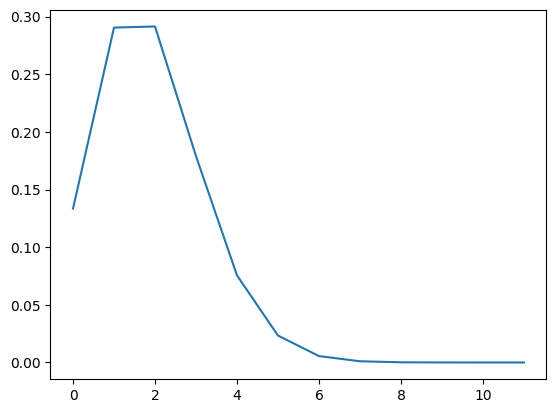

In [396]:
plt.plot(csd)

In [397]:
"""
templTM = lTM.iloc[0:len(lTM),1:len(lTM)+1]
#tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)
#s = tempTM.sum(axis = 1)
#s[0]
lmat = templTM.to_numpy()
#print(np.matrix(lmat))

lst = lmat
for i in range(0,100000):
    lst = np.matmul(lmat,lst) #mat!
    #st = st/st.sum(axis=1)
    
lst[0]
"""

'\ntemplTM = lTM.iloc[0:len(lTM),1:len(lTM)+1]\n#tempTM = tempTM.div(tempTM.sum(axis=1), axis=0)\n#s = tempTM.sum(axis = 1)\n#s[0]\nlmat = templTM.to_numpy()\n#print(np.matrix(lmat))\n\nlst = lmat\nfor i in range(0,100000):\n    lst = np.matmul(lmat,lst) #mat!\n    #st = st/st.sum(axis=1)\n    \nlst[0]\n'

In [398]:
#mat2 = mat.transpose()
#mat2

In [399]:
"""
st = mat2
for i in range(0,50):
    st = np.matmul(st,st)
    
st.transpose()[0]
"""

'\nst = mat2\nfor i in range(0,50):\n    st = np.matmul(st,st)\n    \nst.transpose()[0]\n'

In [400]:
#linalg.eig(mat, left = True)[0]

In [401]:
#linalg.eig(mat2, left = True)[0]

Dynamic Part

In [402]:
def it():
    t = len(LobH)
    LobH.append(0)
    CatH.append(0)
    ps = pSS1()
    for i in range(0,nPPL):
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (mF * np.random.normal(loc = 1, scale = .5)))):
            LobH[t] = LobH[t] + 1
            
    for i in range(0,LobH[t]):
        if random.random() < pCat():
            CatH[t] = CatH[t] + 1

In [403]:
#nPPL = 100
for i in range(0,10000):
    it()


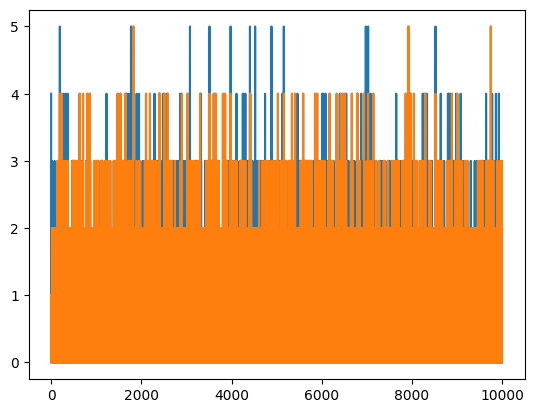

In [404]:
plt.plot(LobH)
plt.plot(CatH)

(array([3981.,    0., 3771.,    0., 1705.,    0.,  437.,    0.,   92.,
          15.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

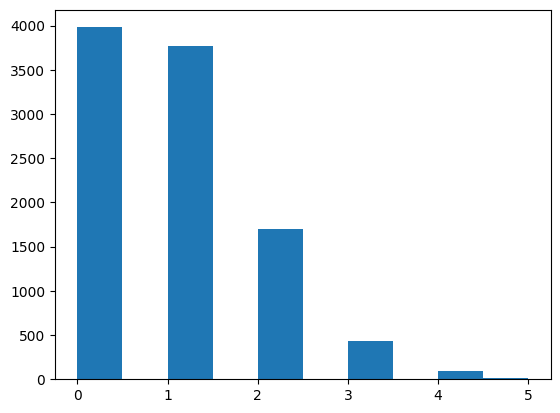

In [419]:
plt.hist(LobH)

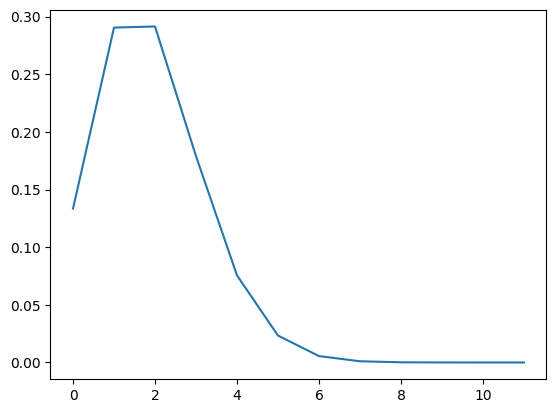

In [418]:
plt.plot(csd)

(array([4.809e+03, 0.000e+00, 3.570e+03, 0.000e+00, 1.304e+03, 0.000e+00,
        2.620e+02, 0.000e+00, 5.300e+01, 3.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

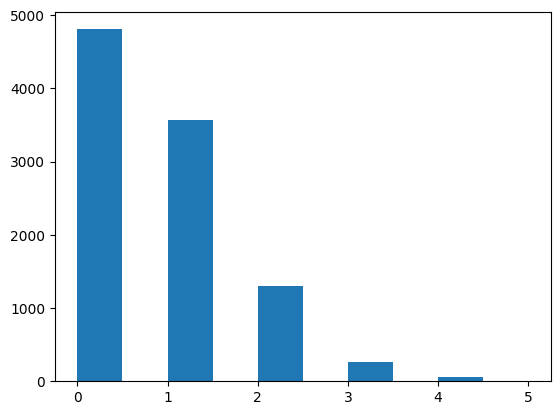

In [406]:
plt.hist(CatH)

In [407]:
for i in range(0,9+1):
    print(i)

0
1
2
3
4
5
6
7
8
9
